In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample_submission.csv
/kaggle/input/train.csv
/kaggle/input/test.csv


# 1. Importing Libraries

In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn models
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Other machine learning libraries
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [3]:
import os
print(os.listdir('/kaggle/input/'))

['sample_submission.csv', 'train.csv', 'test.csv']


In [4]:
train = pd.read_csv('/kaggle/input/train.csv')
test = pd.read_csv('/kaggle/input/test.csv')

In [5]:
desc = train.describe()

# Add a row for unique value counts
unique_counts = pd.DataFrame(train.nunique()).T  # Get unique counts and transpose
unique_counts.index = ['Unique Values']  # Rename the index for clarity

# Concatenate the description with unique counts
combined = pd.concat([desc, unique_counts], ignore_index=False)

# Apply new styling
styled_combined = combined.style.set_properties(**{
    "background-color": "#f3f4f6",  # Light gray for a soft look
    "color": "#333333",              # Darker grey for better readability
    "border": "2px solid #1e88e5",   # A deeper blue border
    "font-weight": "bold"            # Optional: makes the text bolder
}).set_table_styles([
    {"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]}  # Header styles in a darker blue
]).format(precision=2)  # Format all values to show 2 decimal places

# Styled DataFrame
styled_combined


,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness
count,140700.00,140700.00,27897.00,112782.00,27898.00,27897.00,112790.00,140700.00,140696.00,140700.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,70349.50,40.39,3.14,3.00,7.66,2.94,2.97,6.25,2.99,0.18,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
std,40616.74,12.38,1.38,1.41,1.46,1.36,1.42,3.85,1.41,0.39,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,0.00,18.00,1.00,1.00,5.03,1.00,1.00,0.00,1.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
25%,35174.75,29.00,2.00,2.00,6.29,2.00,2.00,3.00,2.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
50%,70349.50,42.00,3.00,3.00,7.77,3.00,3.00,6.00,3.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
75%,105524.25,51.00,4.00,4.00,8.92,4.00,4.00,10.00,4.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
max,140699.00,60.00,5.00,5.00,10.00,5.00,5.00,12.00,5.00,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Unique Values,140700.00,43.00,5.00,5.00,331.00,5.00,5.00,13.00,5.00,2.00,422.00,2.00,98.00,2.00,64.00,36.00,23.00,115.00,2.00,2.00


# 2. Exploring train dataset

In [6]:
# Display the first few rows with styling
formatted_head = train.head().style.set_properties(**{
    "background-color": "#f9f9f9", 
    "color": "#333333",            
    "border": "1px solid #ccc",
    "font-weight": "normal"
}).set_table_styles([
    {"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]}  # Header styling
]).format(precision=2)

# Display the styled DataFrame
formatted_head


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.00,Ludhiana,Working Professional,Chef,nan,5.00,nan,nan,2.00,More than 8 hours,Healthy,BHM,No,1.00,2.00,No,0
1,1,Vivan,Male,26.00,Varanasi,Working Professional,Teacher,nan,4.00,nan,nan,3.00,Less than 5 hours,Unhealthy,LLB,Yes,7.00,3.00,No,1
2,2,Yuvraj,Male,33.00,Visakhapatnam,Student,nan,5.00,nan,8.97,2.00,nan,5-6 hours,Healthy,B.Pharm,Yes,3.00,1.00,No,1
3,3,Yuvraj,Male,22.00,Mumbai,Working Professional,Teacher,nan,5.00,nan,nan,1.00,Less than 5 hours,Moderate,BBA,Yes,10.00,1.00,Yes,1
4,4,Rhea,Female,30.00,Kanpur,Working Professional,Business Analyst,nan,1.00,nan,nan,1.00,5-6 hours,Unhealthy,BBA,Yes,9.00,4.00,Yes,0


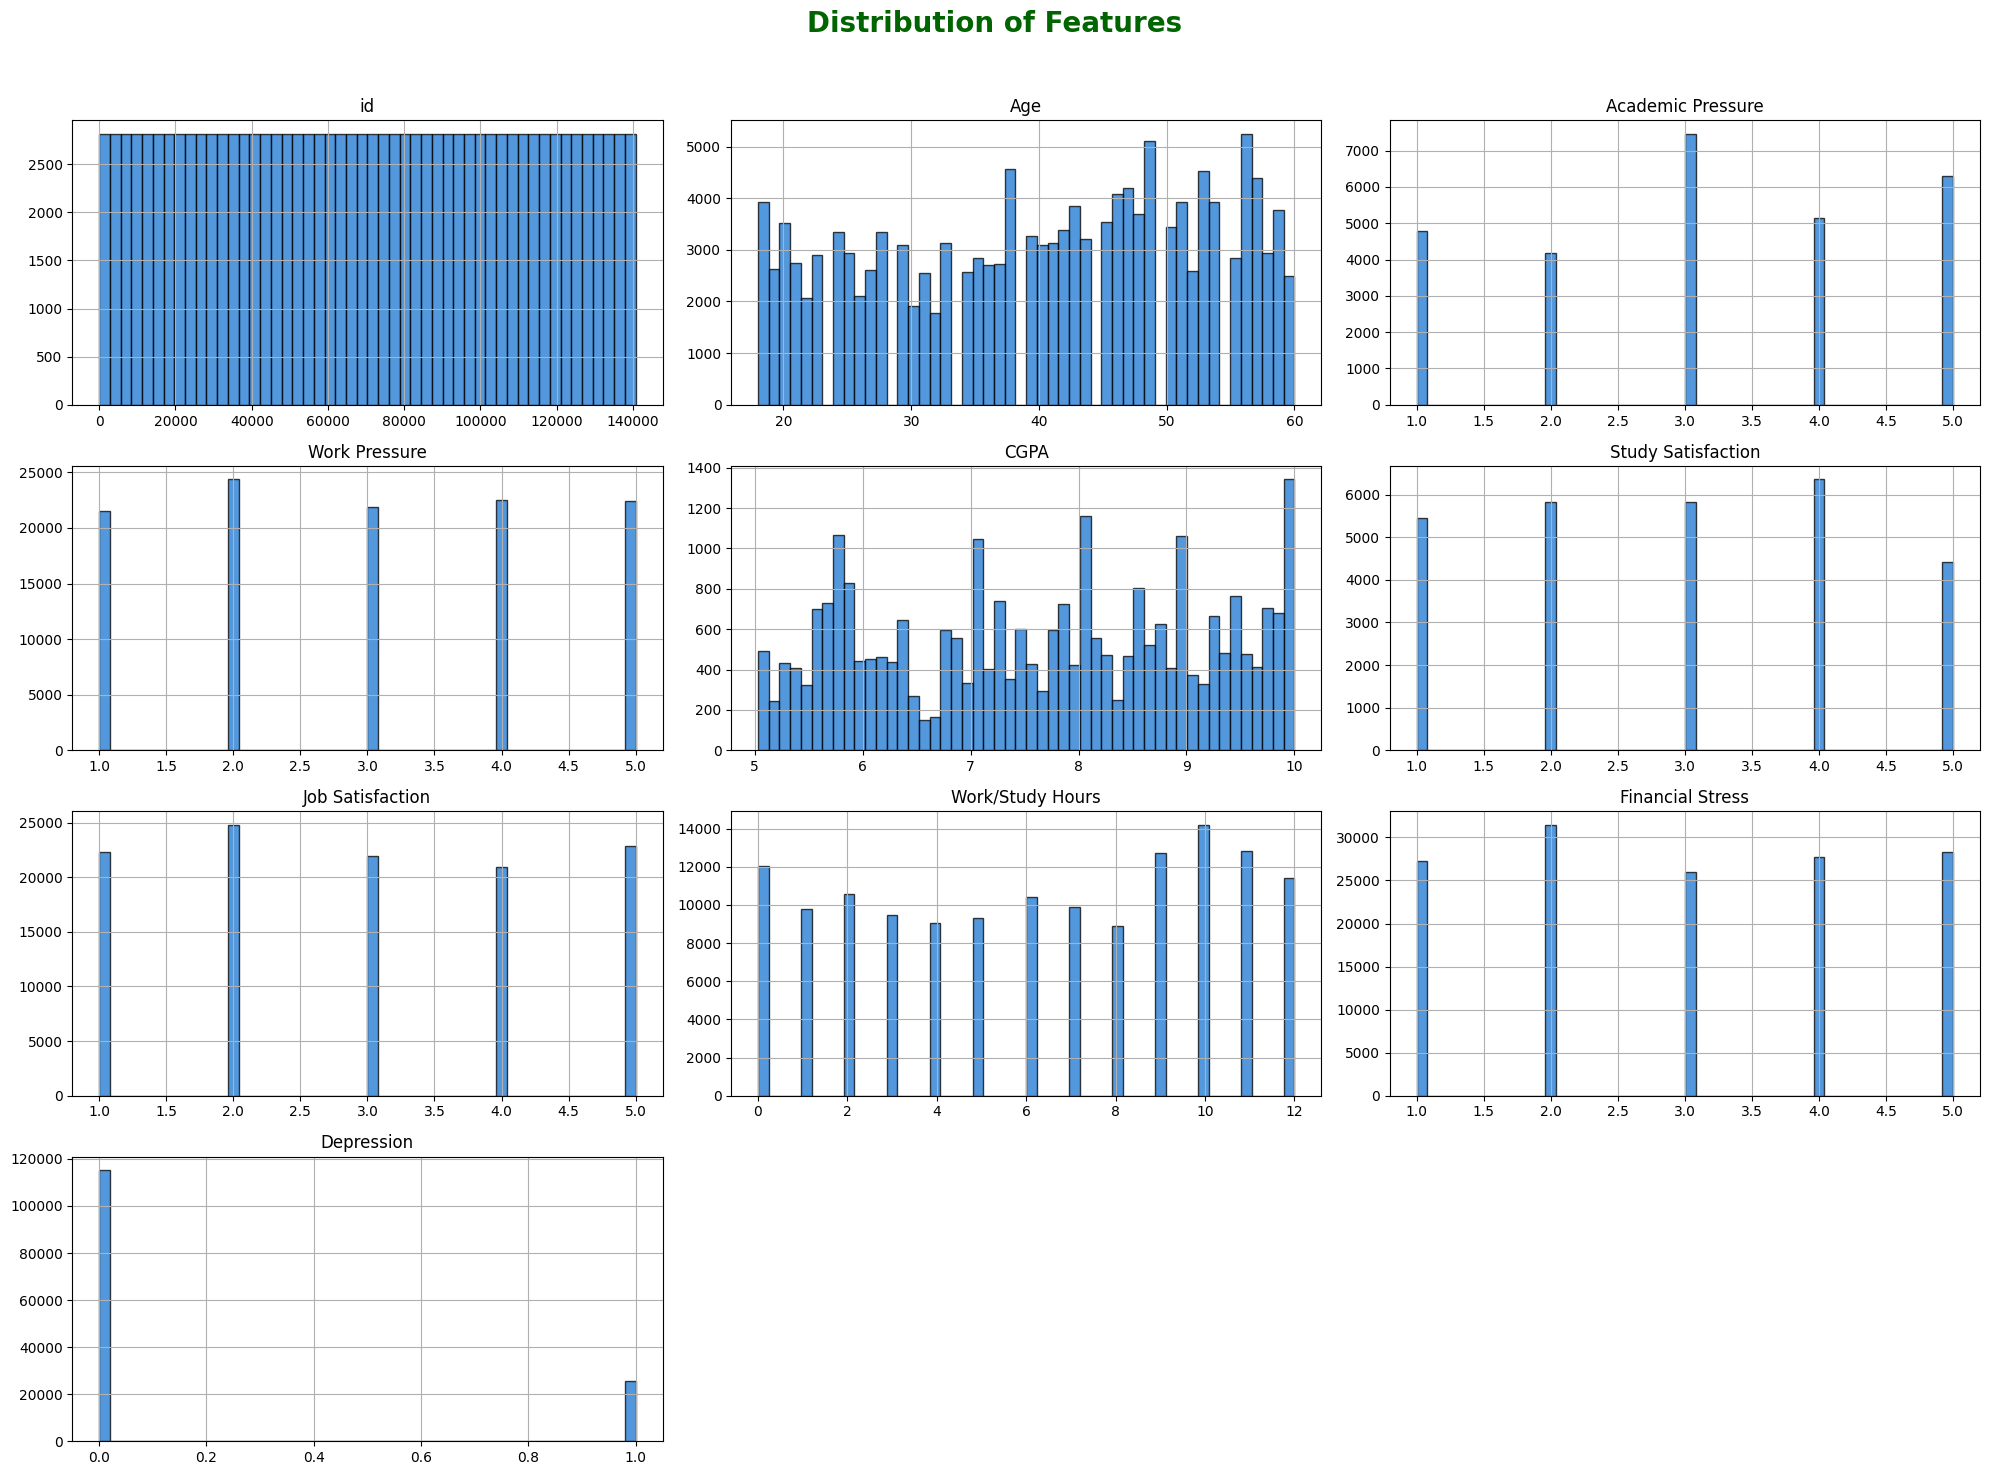

In [7]:
train.hist(
    bins=50, 
    figsize=(20, 15), 
    color='#1976d2', 
    edgecolor='black',
    alpha=0.75
)

# Add global title and adjust layout
plt.suptitle("Distribution of Features", fontsize=20, fontweight='bold', color='darkgreen')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


# 3. Understanding each variable

In [8]:
#For numerical variables, we can use the describe method to understand the value range and identify outliers.
train.describe().style.format(precision=2).background_gradient(cmap="Blues")

#There seems to be no outliers, but we can double check Work/Study Hours to check if there any outlier or not

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.00,140700.00,27897.00,112782.00,27898.00,27897.00,112790.00,140700.00,140696.00,140700.00
mean,70349.50,40.39,3.14,3.00,7.66,2.94,2.97,6.25,2.99,0.18
std,40616.74,12.38,1.38,1.41,1.46,1.36,1.42,3.85,1.41,0.39
min,0.00,18.00,1.00,1.00,5.03,1.00,1.00,0.00,1.00,0.00
25%,35174.75,29.00,2.00,2.00,6.29,2.00,2.00,3.00,2.00,0.00
50%,70349.50,42.00,3.00,3.00,7.77,3.00,3.00,6.00,3.00,0.00
75%,105524.25,51.00,4.00,4.00,8.92,4.00,4.00,10.00,4.00,0.00
max,140699.00,60.00,5.00,5.00,10.00,5.00,5.00,12.00,5.00,1.00


In [9]:
def outlier_check(df):
    '''This will help us to check for the outliers in the numerical columns'''
    # Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Step 2: Calculate the upper and lower bound
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Step 3: Identify outliers
    outliers = df[(df < lower_bound) | (df > upper_bound)]

    # Output message based on the presence of outliers
    if outliers.empty:
        return "There are no outliers."
    else:
        return f"Outliers present: {outliers.values}"


result_tr = outlier_check(train['Work/Study Hours'])
result_test = outlier_check(test['Work/Study Hours'])
print(result_test)


There are no outliers.


*1.Working Professional or Student

In [10]:
train['Working Professional or Student'].value_counts()
test['Working Professional or Student'].value_counts()

Working Professional or Student
Working Professional    75028
Student                 18772
Name: count, dtype: int64

2. City

In [11]:
# Combine the 'City' column from test and train datasets
temp_1 = pd.concat([test[['City']], train[['City']]], ignore_index=True)

# Convert city names to lowercase for consistency
temp_1['City'] = temp_1['City'].str.lower()
city_counts = temp_1['City'].value_counts()
frequent_cities = city_counts[city_counts > 50].index.tolist()  # Convert to a list

# Update train and test datasets, marking infrequent cities as 'Others'
train['City'] = train['City'].str.lower().apply(lambda x: x if x in frequent_cities else 'others')
test['City'] = test['City'].str.lower().apply(lambda x: x if x in frequent_cities else 'others')
print(frequent_cities)

['kalyan', 'patna', 'vasai-virar', 'kolkata', 'ahmedabad', 'meerut', 'ludhiana', 'rajkot', 'srinagar', 'visakhapatnam', 'pune', 'mumbai', 'indore', 'agra', 'vadodara', 'surat', 'varanasi', 'hyderabad', 'kanpur', 'jaipur', 'lucknow', 'thane', 'nagpur', 'bangalore', 'chennai', 'delhi', 'ghaziabad', 'bhopal', 'faridabad', 'nashik']


In [12]:
# Count occurrences of each city in the train dataset
train_city_counts = train['City'].value_counts().reset_index()
train_city_counts.columns = ['City', 'Count']  # Rename columns for clarity

# Count occurrences of each city in the test dataset
test_city_counts = test['City'].value_counts().reset_index()
test_city_counts.columns = ['City', 'Count']  # Rename columns for clarity

# Display formatted train city counts
print("Train City Counts:")
train_styled = train_city_counts.style.set_properties(**{
    "background-color": "#f9f9f9",
    "color": "#333333",
    "border": "1px solid #ccc",
    "font-weight": "normal" 
}).set_table_styles([
    {"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]} 
])

# Display formatted test city counts
print("\nTest City Counts:")
test_styled = test_city_counts.style.set_properties(**{
    "background-color": "#f9f9f9", 
    "color": "#333333",            
    "border": "1px solid #ccc",    
    "font-weight": "normal"     
}).set_table_styles([
    {"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]} 
])

# To display the styled DataFrames 
train_styled

Train City Counts:

Test City Counts:


,City,Count
0,kalyan,6591
1,patna,5924
2,vasai-virar,5765
3,kolkata,5689
4,ahmedabad,5613
5,meerut,5528
6,ludhiana,5226
7,pune,5210
8,rajkot,5207
9,visakhapatnam,5176


In [13]:
#Mapping Working profession to 1 and Student to 0 
mapping = { "Working Professional":1,"Student":0}
train['Working Professional or Student'] = train['Working Professional or Student'].map(mapping)
test['Working Professional or Student'] = test['Working Professional or Student'].map(mapping)

3. Degree

In [14]:
# Combine the 'Degree' column from test and train
temp_2 = pd.concat([test[['Degree']], train[['Degree']]], ignore_index=True)
degree_counts = temp_2['Degree'].value_counts()
frequent_degree = degree_counts[degree_counts > 20].index
print(frequent_degree)

Index(['Class 12', 'B.Ed', 'B.Arch', 'B.Com', 'B.Pharm', 'BCA', 'M.Ed', 'MCA',
       'BBA', 'BSc', 'MSc', 'LLM', 'M.Pharm', 'M.Tech', 'B.Tech', 'LLB', 'BHM',
       'MBA', 'BA', 'ME', 'MD', 'MHM', 'BE', 'M.Com', 'PhD', 'MBBS', 'MA'],
      dtype='object', name='Degree')


In [15]:
# Mark infrequent cities as 'Others'
train['Degree'] = train['Degree'].apply(lambda x: x if x in frequent_degree else 'Others')
test['Degree'] = test['Degree'].apply(lambda x: x if x in frequent_degree else 'Others')

4. Profession 

In [16]:
# Fill 'Profession' with 'Student' where 'Working Professional or Student' is 0 and 'Profession' is NaN
train.loc[(train['Working Professional or Student'] == 0) & (train['Profession'].isna()), 'Profession'] = 'Student'
test.loc[(test['Working Professional or Student'] == 0) & (test['Profession'].isna()), 'Profession'] = 'Student'

In [17]:
# Step 1: Create a mapping of Degree -> most common Profession, where there are multiple profession, we have taken degree with highest number of profession
degree_profession_mapping = (
    train[train['Working Professional or Student'] == 1]
    .groupby('Degree')['Profession']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .to_dict()
)

In [18]:
print(degree_profession_mapping)

{'B.Arch': 'Teacher', 'B.Com': 'Accountant', 'B.Ed': 'Teacher', 'B.Pharm': 'Teacher', 'B.Tech': 'Data Scientist', 'BA': 'Customer Support', 'BBA': 'HR Manager', 'BCA': 'Data Scientist', 'BE': 'Pilot', 'BHM': 'Chef', 'BSc': 'Teacher', 'Class 12': 'Teacher', 'LLB': 'Teacher', 'LLM': 'Teacher', 'M.Com': 'Customer Support', 'M.Ed': 'Content Writer', 'M.Pharm': 'Chemist', 'M.Tech': 'UX/UI Designer', 'MA': 'Teacher', 'MBA': 'Teacher', 'MBBS': 'Pharmacist', 'MCA': 'Consultant', 'MD': 'Pharmacist', 'ME': 'Content Writer', 'MHM': 'Chef', 'MSc': 'Entrepreneur', 'Others': 'Teacher', 'PhD': 'Plumber'}


In [19]:
# Step 2: Update missing Profession values based on Degree
train.loc[(train['Working Professional or Student'] == 1) & (train['Profession'].isna()), 'Profession'] = train.loc[ (train['Working Professional or Student'] == 1) & (train['Profession'].isna()),
    'Degree'].map(degree_profession_mapping)

test.loc[(test['Working Professional or Student'] == 1) & (test['Profession'].isna()), 'Profession'] = test.loc[(test['Working Professional or Student'] == 1) & (test['Profession'].isna()), 
    'Degree'
].map(degree_profession_mapping)

In [20]:
# Step 3: Combine 'Profession' columns from train and test datasets
temp_2 = pd.concat([test[['Profession']], train[['Profession']]], ignore_index=True)
profession_counts = temp_2['Profession'].value_counts()
frequent_professions = profession_counts[profession_counts > 20].index
print(frequent_professions)


Index(['Teacher', 'Student', 'Content Writer', 'Architect', 'Consultant',
       'HR Manager', 'Pharmacist', 'Doctor', 'Business Analyst', 'Chemist',
       'Entrepreneur', 'Chef', 'Educational Consultant', 'Data Scientist',
       'Researcher', 'Lawyer', 'Customer Support', 'Pilot',
       'Marketing Manager', 'Travel Consultant', 'Judge', 'Manager', 'Plumber',
       'Sales Executive', 'Electrician', 'Financial Analyst',
       'Software Engineer', 'Civil Engineer', 'UX/UI Designer',
       'Digital Marketer', 'Finanancial Analyst', 'Accountant',
       'Mechanical Engineer', 'Graphic Designer', 'Research Analyst',
       'Investment Banker'],
      dtype='object', name='Profession')


In [21]:
# Mark infrequent Profession as 'Others'
train['Profession'] = train['Profession'].apply(lambda x: x if x in frequent_professions else 'Others')
test['Profession'] = test['Profession'].apply(lambda x: x if x in frequent_professions else 'Others')

In [22]:
#Creating one more Categories
# Create a dictionary to map professions to categories
profession_to_category = {
    'Teacher': 'Education',
    'Student': 'Education',
    'Content Writer': 'Education',
    'Architect': 'Engineering',
    'Consultant': 'Consulting & Management',
    'HR Manager': 'Consulting & Management',
    'Pharmacist': 'Healthcare',
    'Doctor': 'Healthcare',
    'Business Analyst': 'Finance & Accounting',
    'Chemist': 'Science & Research',
    'Entrepreneur': 'Consulting & Management',
    'Chef': 'Skilled Trades & Labor',
    'Educational Consultant': 'Education',
    'Data Scientist': 'Science & Research',
    'Researcher': 'Science & Research',
    'Lawyer': 'Law & Governance',
    'Customer Support': 'Consulting & Management',
    'Pilot': 'Law & Governance',
    'Marketing Manager': 'Consulting & Management',
    'Travel Consultant': 'Consulting & Management',
    'Judge': 'Law & Governance',
    'Manager': 'Consulting & Management',
    'Sales Executive': 'Consulting & Management',
    'Plumber': 'Skilled Trades & Labor',
    'Electrician': 'Skilled Trades & Labor',
    'Financial Analyst': 'Finance & Accounting',
    'Software Engineer': 'Engineering',
    'Civil Engineer': 'Engineering',
    'UX/UI Designer': 'Engineering',
    'Digital Marketer': 'Consulting & Management',
    'Financial Analyst': 'Finance & Accounting',
    'Accountant': 'Finance & Accounting',
    'Mechanical Engineer': 'Engineering',
    'Graphic Designer': 'Creative & Design',
    'Research Analyst': 'Consulting & Management',
    'Investment Banker': 'Finance & Accounting'
}

# Map the profession column to categories
train['Profession Category'] = train['Profession'].map(profession_to_category)
test['Profession Category'] = test['Profession'].map(profession_to_category)

# Check the result
print(train[['Profession', 'Profession Category']].head())


         Profession     Profession Category
0              Chef  Skilled Trades & Labor
1           Teacher               Education
2           Student               Education
3           Teacher               Education
4  Business Analyst    Finance & Accounting


4. Work/Academic pressure

In [23]:
#We will combine the work and academic pressue into one column, apart from Financial pressume this is one of the most important factor

#Understanding if there is any value where both are Work and Academic pressure are applicable
# Filter rows where both 'Work Pressure' and 'Academic Pressure' are non-NaN
temp_p = train[(train['Work Pressure'].notna()) & (train['Academic Pressure'].notna())]

# Print the values, no such pressure exist
print(temp_p)

# Function to combine 'Work Pressure' and 'Academic Pressure' into one 'Pressure' column
def combine_pressure(data):
    # Create a new 'Pressure' column and initialize it as None
    data['Pressure'] = None
    for index, row in data.iterrows():
        if pd.notna(row['Work Pressure']): 
            data.at[index, 'Pressure'] = row['Work Pressure']
        elif pd.notna(row['Academic Pressure']):
            data.at[index, 'Pressure'] = row['Academic Pressure']
    data['Pressure'] = data['Pressure'].fillna(data['Pressure'].mean())

    return data


Empty DataFrame
Columns: [id, Name, Gender, Age, City, Working Professional or Student, Profession, Academic Pressure, Work Pressure, CGPA, Study Satisfaction, Job Satisfaction, Sleep Duration, Dietary Habits, Degree, Have you ever had suicidal thoughts ?, Work/Study Hours, Financial Stress, Family History of Mental Illness, Depression, Profession Category]
Index: []

[0 rows x 21 columns]


In [24]:
train = combine_pressure(train)
test = combine_pressure(test)
print(train[['Work Pressure', 'Academic Pressure', 'Pressure']].head())
print(test[['Work Pressure', 'Academic Pressure', 'Pressure']].head())

/tmp/ipykernel_71/2172330496.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Pressure'] = data['Pressure'].fillna(data['Pressure'].mean())


   Work Pressure  Academic Pressure  Pressure
0            5.0                NaN       5.0
1            4.0                NaN       4.0
2            NaN                5.0       5.0
3            5.0                NaN       5.0
4            1.0                NaN       1.0
   Work Pressure  Academic Pressure  Pressure
0            2.0                NaN       2.0
1            2.0                NaN       2.0
2            4.0                NaN       4.0
3            NaN                5.0       5.0
4            5.0                NaN       5.0


/tmp/ipykernel_71/2172330496.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Pressure'] = data['Pressure'].fillna(data['Pressure'].mean())


In [25]:
def fill_missing_cgpa(data):
    # Calculate median CGPA for each group
    median_cgpa = data.groupby('Working Professional or Student')['CGPA'].median()
    
    # Fill missing CGPA values based on group median
    data['CGPA'] = data.apply(
        lambda row: median_cgpa[row['Working Professional or Student']] if pd.isna(row['CGPA']) else row['CGPA'], 
        axis=1
    )
    return data

# Apply the function to both train and test datasets
train = fill_missing_cgpa(train)
test = fill_missing_cgpa(test)


In [26]:
# Filter rows where both 'Study Satisfaction' and 'Job Satisfaction' are not null
temp_s = train[(train['Study Satisfaction'].notna()) & (train['Job Satisfaction'].notna())]

# Print the count of rows
print("Count of rows where both 'Study Satisfaction' and 'Job Satisfaction' are not null:")
print(temp_s.shape[0])


Count of rows where both 'Study Satisfaction' and 'Job Satisfaction' are not null:
2


In [27]:
#Creating a single function for both train and test
def combine_satisfaction(data):
    data['Satisfaction'] = None
    for index, row in data.iterrows():
        if pd.notna(row['Job Satisfaction']): 
            data.at[index, 'Satisfaction'] = row['Job Satisfaction']
        elif pd.notna(row['Study Satisfaction']):  
            data.at[index, 'Satisfaction'] = row['Study Satisfaction']
    data['Satisfaction'] = data['Satisfaction'].fillna(data['Satisfaction'].mean())
    return data

In [28]:
train = combine_satisfaction(train)
test = combine_satisfaction(test)
print(train[['Job Satisfaction', 'Study Satisfaction', 'Satisfaction']].head())

/tmp/ipykernel_71/2460119255.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Satisfaction'] = data['Satisfaction'].fillna(data['Satisfaction'].mean())


   Job Satisfaction  Study Satisfaction  Satisfaction
0               2.0                 NaN           2.0
1               3.0                 NaN           3.0
2               NaN                 2.0           2.0
3               1.0                 NaN           1.0
4               1.0                 NaN           1.0


/tmp/ipykernel_71/2460119255.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Satisfaction'] = data['Satisfaction'].fillna(data['Satisfaction'].mean())


In [29]:
train['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1-6 hours                4
No                       4
9-11 hours               2
10-11 hours              2
Sleep_Duration           2
Unhealthy                2
45                       2
8-9 hours                2
10-6 hours               1
9-5                      1
45-48 hours              1
3-6 hours                1
Work_Study_Hours         1
49 hours                 1
than 5 hours             1
Pune                     1
9-6 hours                1
8 hours                  1
35-36 hours              1
Indore                   1
1-3 hours                1
55-66 hours              1
Moderate                 1
40-45 hours              1
1-2 hours                1
9-5 hours                1
Name: count, 

In [30]:
def Sleep_func(df, column_name):
    df['Sleep_Duration_bucket'] = None
    
    for index, value in df[column_name].items():
        if value == 'Less than 5 hours':
            df.loc[index, 'Sleep_Duration_bucket'] = 1
        elif value == '5-6 hours':
            df.loc[index, 'Sleep_Duration_bucket'] = 2
        elif value == '7-8 hours':
            df.loc[index, 'Sleep_Duration_bucket'] = 3
        elif value == 'More than 8 hours':
            df.loc[index, 'Sleep_Duration_bucket'] = 4

    df.dropna(subset=['Sleep_Duration_bucket'], inplace=True)

    return df


In [31]:
Sleep_func(test,"Sleep Duration");
Sleep_func(train,"Sleep Duration");

In [32]:
train['Dietary Habits'].value_counts()

Dietary Habits
Moderate             49670
Unhealthy            46201
Healthy              44723
Yes                      2
No                       2
More Healthy             2
No Healthy               1
Class 12                 1
Indoor                   1
Male                     1
Vegas                    1
M.Tech                   1
Less Healthy             1
1.0                      1
Electrician              1
Hormonal                 1
Mihir                    1
Less than Healthy        1
3                        1
Gender                   1
BSc                      1
Pratham                  1
2                        1
Name: count, dtype: int64

In [33]:
def Dietary_Habits_func(df, column_name):
    df['Dietary_Habits_bucket'] = 2 

    for index, value in df[column_name].items():
        if value == 'Unhealthy':
            df.loc[index, 'Dietary_Habits_bucket'] = 1  # Unhealthy
        elif value == 'Healthy':
            df.loc[index, 'Dietary_Habits_bucket'] = 3  # Healthy

    return df


In [34]:
Dietary_Habits_func(train, 'Dietary Habits');
Dietary_Habits_func(test, 'Dietary Habits');

In [35]:
def suicidal_thoughts_encoding(df, column_name):
    df['Suicidal_thoughts'] = None
    
    for index, value in df[column_name].items():
        if value == 'Yes':
            df.loc[index, 'Suicidal_thoughts'] = 0
        elif value == 'No':
            df.loc[index, 'Suicidal_thoughts'] = 1

    return df


In [36]:
suicidal_thoughts_encoding(train, 'Have you ever had suicidal thoughts ?');
suicidal_thoughts_encoding(test, 'Have you ever had suicidal thoughts ?');


In [37]:
train['Family History of Mental Illness'].value_counts()

Family History of Mental Illness
No     70715
Yes    69906
Name: count, dtype: int64

In [38]:
def family_history_encoding(df, column_name):
    df['Family_history'] = None
    
    for index, value in df[column_name].items():
        if value == 'Yes':
            df.loc[index, 'Family_history'] = 0
        elif value == 'No':
            df.loc[index, 'Family_history'] = 1

    return df


In [39]:
family_history_encoding(train, 'Family History of Mental Illness');
family_history_encoding(test, 'Family History of Mental Illness');

In [40]:
train['Financial Stress'] = train['Financial Stress'].fillna(0)

# 4. Relationship between variables

In [41]:

profession = train.groupby(['Working Professional or Student', 'Age']).agg(Number_of_people=('id', 'count')).reset_index()
profession = profession.sort_values(by='Age', ascending=True)

wp = profession[profession['Working Professional or Student'] == 1]  
student = profession[profession['Working Professional or Student'] == 0] 

# Optionally print the results
print("Working Professionals:")
print(wp)

print("\nStudents:")
print(student)


Working Professionals:
    Working Professional or Student   Age  Number_of_people
34                                1  18.0              2334
35                                1  19.0              1074
36                                1  20.0              1278
37                                1  21.0              1016
38                                1  22.0               906
39                                1  23.0              1254
40                                1  24.0              1097
41                                1  25.0              1147
42                                1  26.0               952
43                                1  27.0              1150
44                                1  28.0              1204
45                                1  29.0              1147
46                                1  30.0               767
47                                1  31.0              1132
48                                1  32.0               523
49               

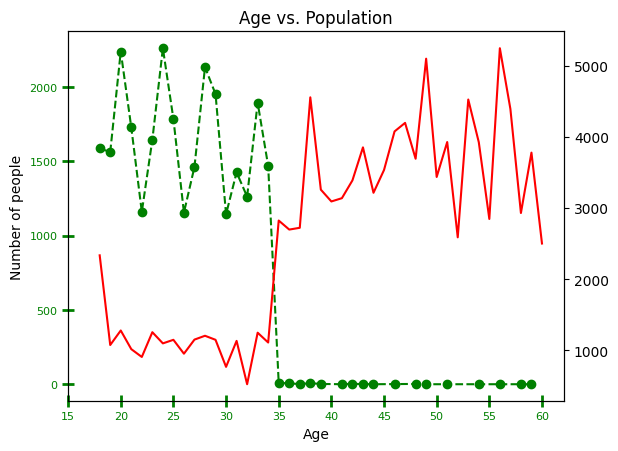

In [42]:
fig, ax = plt.subplots()

#Student
ax.plot(student['Age'], student['Number_of_people'], color ='g', linestyle="--", marker ="o")

#Working professional
ax2 = ax.twinx()
ax2.plot(wp['Age'], wp['Number_of_people'], color ='r', linestyle="-", marker ="")

#Creating labels
ax.set_title("Age vs. Population")
ax.set_xlabel("Age")
ax.set_ylabel("Number of people")

# Adjust tick intervals for x-axis
ax.set_xticks(range(15, 65, 5)) 

# Customize tick parameters for x-axis and y-axis
ax.tick_params(axis='x', colors='green', length=8, width=2, direction='inout', labelsize=8)
ax.tick_params(axis='y', colors='green', length=8, width=2, direction='inout', labelsize=8)  

plt.show()


In [43]:
age_dep = train.groupby('Age')['Depression'].agg(Count='count', Sum='sum').reset_index()
age_dep.columns = ['Age','Pop','Dep_pop']
age_dep['Dep %'] = round((age_dep['Dep_pop'] / age_dep['Pop']) * 100,1)
age_dep.head()


,Age,Pop,Dep_pop,Dep %
0,18.0,3920,2780,70.9
1,19.0,2634,1665,63.2
2,20.0,3514,2184,62.2
3,21.0,2742,1841,67.1
4,22.0,2065,1087,52.6


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


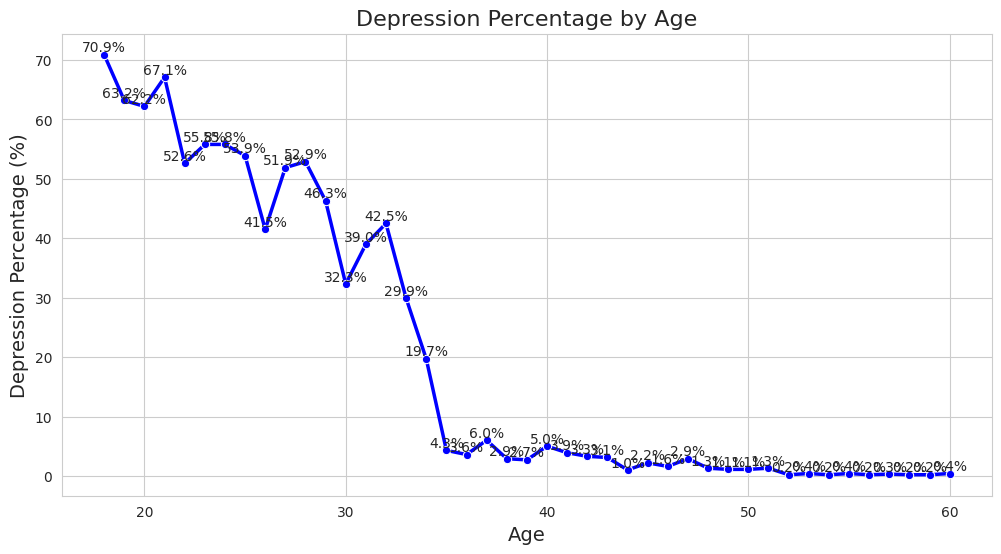

In [44]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

line_plot = sns.lineplot(
    x='Age',
    y='Dep %',
    data=age_dep,
    marker='o',
    color='blue',
    linewidth=2.5
)

# Setting title and labels
line_plot.set_title("Depression Percentage by Age", fontsize=16)
line_plot.set_xlabel("Age", fontsize=14)
line_plot.set_ylabel("Depression Percentage (%)", fontsize=14)

#Add grid lines
plt.grid(visible=True)

# Annotate points with their values
for i, row in age_dep.iterrows():
    plt.text(
        row['Age'], 
        row['Dep %'], 
        f"{row['Dep %']:.1f}%", 
        fontsize=10,
        horizontalalignment='center',
        verticalalignment='bottom'
    )

plt.show()


In [45]:
city_dep = train.groupby('City')['Depression'].agg(Count='count', Sum='sum').reset_index()
city_dep.columns = ['City','Population','Dep_population']
city_dep = city_dep[city_dep['Population'] > 50]
city_dep['Depressed %'] = city_dep['Dep_population']/city_dep['Population']

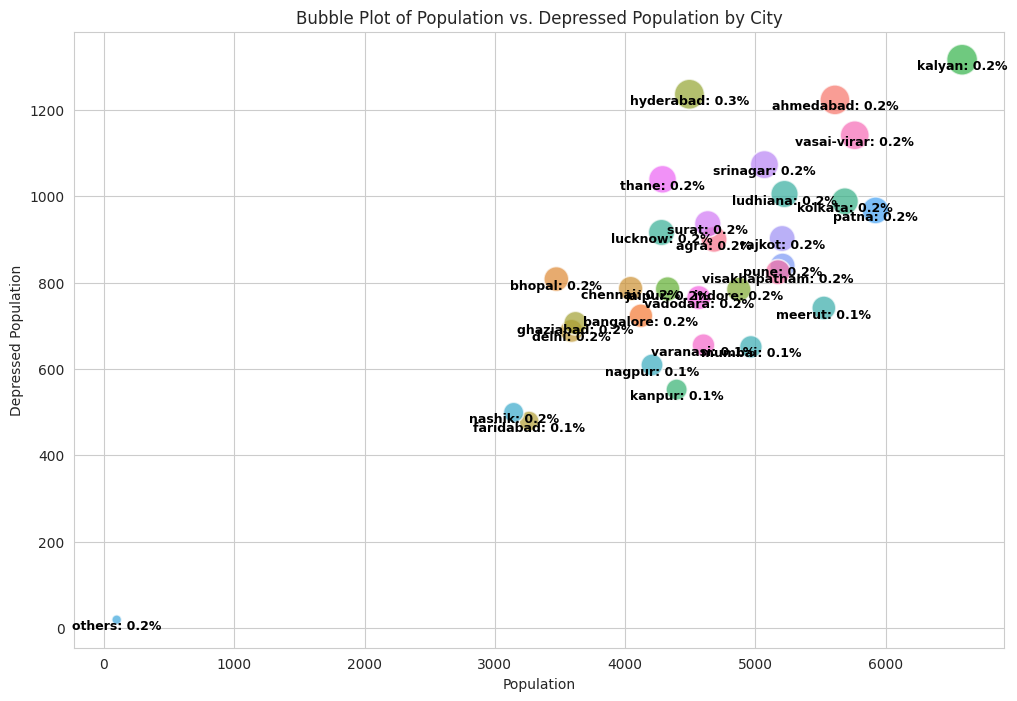

In [46]:
# Creating a color palette based on the unique cities
unique_cities = city_dep['City'].unique()
palette = sns.color_palette("husl", len(unique_cities))

# Map colors to cities
color_map = {city: palette[i] for i, city in enumerate(unique_cities)}

#Creating a scatter plot
plt.figure(figsize=(12, 8)) 
scatter = sns.scatterplot(
    x='Population',
    y='Dep_population',
    data=city_dep,
    size='Dep_population',
    sizes=(50, 500),
    alpha=0.7,
    legend=False,
    hue='City',
    palette=color_map
)

# Annotate the bubbles with the city names and "Depressed %" values
for i in range(city_dep.shape[0]):
    plt.text(
        city_dep['Population'].iloc[i],
        city_dep['Dep_population'].iloc[i],
        f"{city_dep['City'].iloc[i]}: {city_dep['Depressed %'].iloc[i]:.1f}%",  # Include city name
        horizontalalignment='center',
        verticalalignment='top',
        fontsize=9,
        color='black', 
        weight='bold'
    )

# Set the title and labels
plt.title('Bubble Plot of Population vs. Depressed Population by City')
plt.xlabel('Population')
plt.ylabel('Depressed Population')

# Show the plot
plt.show()


In [49]:
# Drop unnecessary columns from train_f
train_f = train.drop(columns=[
    'id', 'Name', 'Study Satisfaction', 'Job Satisfaction', 'Academic Pressure', 
    'Work Pressure', 'Sleep Duration', 
    'Dietary Habits', 'Have you ever had suicidal thoughts ?', 
    'Family History of Mental Illness', 'Depression','Profession Category'
])

# Drop unnecessary columns from test_f
test_f = test.drop(columns=[
    'id', 'Name', 'Study Satisfaction', 'Job Satisfaction', 'Academic Pressure', 
    'Work Pressure', 'Sleep Duration', 
    'Dietary Habits', 'Have you ever had suicidal thoughts ?', 
    'Family History of Mental Illness','Profession Category'
])


In [51]:
# Count the number of columns in the 'train' DataFrame. Target variables needs to be separated out in the train
column_count = train_f.columns.size
print("Number of columns in the 'train' DataFrame:", column_count)

Number of columns in the 'train' DataFrame: 15


In [52]:
train_y = train[['Depression']].values.ravel()

In [53]:
#Doing hot encoding
def encode_and_concatenate(df, columns_to_encode):
    encoded_df = pd.get_dummies(df[columns_to_encode]).astype(int)
    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop(columns=columns_to_encode)
    return df

In [55]:
# Columns to encode
columns_to_encode = ['Gender', 'City', 'Profession', 'Degree']

# Applying the function to both train and test data
train_f = encode_and_concatenate(train_f, columns_to_encode)
test_f = encode_and_concatenate(test_f, columns_to_encode)

In [56]:
# Convert specified columns to integer type
train_f['Sleep_Duration_bucket'] = train_f['Sleep_Duration_bucket'].astype(int)
train_f['Dietary_Habits_bucket'] = train_f['Dietary_Habits_bucket'].astype(int)
train_f['Suicidal_thoughts'] = train_f['Suicidal_thoughts'].astype(int)
train_f['Family_history'] = train_f['Family_history'].astype(int)


# Convert specified columns to integer type
test_f['Sleep_Duration_bucket'] = test_f['Sleep_Duration_bucket'].astype(int)
test_f['Dietary_Habits_bucket'] = test_f['Dietary_Habits_bucket'].astype(int)
test_f['Suicidal_thoughts'] = test_f['Suicidal_thoughts'].astype(int)
test_f['Family_history'] = test_f['Family_history'].astype(int)

Scaling Parameters

In [56]:
#Converting Standard_Scaler
import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_f)
x_scaled_df = pd.DataFrame(scaled_data, columns=train_f.columns)
scaled_test_data = scaler.transform(test_f)
x_scaled_test_df = pd.DataFrame(scaled_test_data, columns=test_f.columns)

# 5. Modeling (Student and Working profession together)

In [58]:
models = {
    'rf': RandomForestClassifier(random_state=42),
    'gb': GradientBoostingClassifier(random_state=42),
    'xg': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'lgm': LogisticRegression(random_state=42),
    'catboost': CatBoostClassifier(verbose=0, random_state=42),
    'lgbm': LGBMClassifier(random_state=42, force_col_wise=True),  # Add force_col_wise=True
    'et': ExtraTreesClassifier(random_state=42),
    'ada': AdaBoostClassifier(random_state=42),
    'mlp': MLPClassifier(random_state=42),
    'hgb': HistGradientBoostingClassifier(random_state=42),
}

In [59]:
#Splitting data to train and test split
X_train,X_test,y_train,y_test = train_test_split(x_scaled_df,train_y,test_size = 0.2, random_state = 42)

# a. Ensemble (Soft Voting)

In [ ]:
# Create tuples of model name and instance
estimators = [(name, model) for name, model in models.items()]

# Create the Voting Classifier (use 'soft' voting for probabilities or 'hard' for majority rule)
voting_clf_soft = VotingClassifier(estimators=estimators, voting='soft')

# Fit the Voting Classifier
voting_clf_soft.fit(X_train, y_train)

# Predict on the test set
y_pred_soft = voting_clf_soft.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_soft)
print(f"Voting Classifier Accuracy: {accuracy:.2f}")



In [73]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_soft))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22986
           1       0.84      0.81      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.89     28140
weighted avg       0.94      0.94      0.94     28140



In [62]:
y_voting_soft_result = voting_clf_soft.predict(x_scaled_test_df)

In [64]:
Sub_30_11_v1 = pd.DataFrame()
Sub_30_11_v1['id'] = test['id']  # Add 'id' column from the 'test' DataFrame
Sub_30_11_v1['Predictions'] = y_voting_soft_result  # Add predictions as a new column


# Save the DataFrame as needed (e.g., as CSV or Excel)
Sub_30_11_v1.to_csv("/kaggle/working/Sub_30_11_ensemble_soft_v1.csv", index=False)

# b. Ensemble (Hard Voting)

In [ ]:
# Create tuples of model name and instance
estimators = [(name, model) for name, model in models.items()]

# Create the Voting Classifier (use 'soft' voting for probabilities or 'hard' for majority rule)
voting_clf_hard = VotingClassifier(estimators=estimators, voting='hard')

# Fit the Voting Classifier
voting_clf_hard.fit(X_train, y_train)

# Predict on the test set
y_pred_hard = voting_clf_hard.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Voting Classifier Accuracy: {accuracy:.2f}")


In [ ]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_hard))


In [68]:
y_voting_hard_result = voting_clf_hard.predict(x_scaled_test_df)

In [69]:
Sub_30_11_v2 = pd.DataFrame()
Sub_30_11_v2['id'] = test['id']  # Add 'id' column from the 'test' DataFrame
Sub_30_11_v2['Predictions'] = y_voting_hard_result  # Add predictions as a new column


# Save the DataFrame as needed (e.g., as CSV or Excel)
Sub_30_11_v1.to_csv("/kaggle/working/Sub_30_11_ensemble_soft_v2.csv", index=False)

#Trying RandomForestClassifier

# c. Randomforest model

In [ ]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define parameter grid for Random Forest
param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_depth": [None, 10, 20, 30],  # Maximum depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples to split an internal node
    "min_samples_leaf": [1, 2, 4],    # Minimum samples at a leaf node
    "max_features": ["sqrt", "log2", None],  # Number of features to consider for splits
    "bootstrap": [True, False],       # Whether to use bootstrap sampling
}

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings sampled
    scoring="accuracy",  # Use appropriate scoring metric
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    bootstrap=best_params["bootstrap"],
    random_state=42,
)

# Fit the model to the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))


# d. Using Optuna to hypertune Randomforest

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
import joblib  # Import joblib for saving the model

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 100, 500)  # Number of trees
    max_depth = trial.suggest_int("max_depth", 5, 50, log=True)  # Maximum depth of trees
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)  # Min samples to split a node
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)  # Min samples at a leaf node
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])  # Features to consider
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])  # Bootstrap sampling
    
    # Create the model with the suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
    )
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    return scores.mean()

# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize the study
study.optimize(objective, n_trials=10, n_jobs=-1)  # Adjust n_trials for thoroughness

# Retrieve the best hyperparameters
best_params = study.best_params
print(f"Best Parameters: {best_params}")

# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    bootstrap=best_params["bootstrap"],
    random_state=42,
)

# Fit the model to the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model
file_path = "/kaggle/working/best_rf_model.pkl"
joblib.dump(best_rf_model, file_path)
print(f"Model saved to {file_path}")


In [ ]:
# Make predictions on the test data
y_competition = best_rf_model.predict(test_f)  # Predict using the test features

# Create a DataFrame to store the predictions
Sub_29_11_v2 = pd.DataFrame()  # Updated DataFrame name
Sub_29_11_v2['id'] = test['id']  # Add 'id' column from the 'test' DataFrame
Sub_29_11_v2['Predictions'] = y_competition  # Add predictions as a new column

# Save the DataFrame as needed (e.g., as CSV)
Sub_29_11_v2.to_csv("/kaggle/working/Sub_29_11_v2.csv", index=False)  # Updated file name
print(f"Predictions saved to /kaggle/working/Sub_29_11_v2.csv")


# 6. Modeling - Separate modeling for Working professional and Student

In [68]:
# Columns to convert
columns_to_convert = ['Sleep_Duration_bucket', 'Suicidal_thoughts', 'Family_history']

# Function to convert specified columns to numeric
def convert_columns_to_numeric(df, columns):
    for column in columns:
        try:
            df[column] = pd.to_numeric(df[column], errors='coerce')  # Convert to numeric (float)
        except Exception as e:
            print(f"Error converting column {column}: {e}")
    return df

# Apply the function to both train and test
train = convert_columns_to_numeric(train, columns_to_convert)
test = convert_columns_to_numeric(test, columns_to_convert)

In [80]:
# Define the feature lists
student_features = [
    "Gender", "Age", "City", "Academic Pressure", "CGPA", "Study Satisfaction", 
    "Degree", "Work/Study Hours", 
    "Financial Stress", "Sleep_Duration_bucket", "Dietary_Habits_bucket", 
    "Suicidal_thoughts", "Family_history","Depression"
]

working_profession_features = [
    "Gender", "Age", "City", "Profession", "Work Pressure", "Job Satisfaction",
    "Work/Study Hours", "Financial Stress", "Sleep_Duration_bucket", "Dietary_Habits_bucket", 
    "Suicidal_thoughts", "Family_history","Depression"
]

# Filter the train DataFrame for students (Working Professional or Student = 0)

#Train data
student_df = train[train["Working Professional or Student"] == 0][student_features].copy()
working_profession_df = train[train["Working Professional or Student"] == 1][working_profession_features].copy()



In [81]:
# Define the feature lists
student_features = [
    "Gender", "Age", "City", "Academic Pressure", "CGPA", "Study Satisfaction", 
    "Degree", "Work/Study Hours", 
    "Financial Stress", "Sleep_Duration_bucket", "Dietary_Habits_bucket", 
    "Suicidal_thoughts", "Family_history"
]

working_profession_features = [
    "Gender", "Age", "City", "Profession", "Work Pressure", "Job Satisfaction",
    "Work/Study Hours", "Financial Stress", "Sleep_Duration_bucket", "Dietary_Habits_bucket", 
    "Suicidal_thoughts", "Family_history"
]

# "Profession Category"

#Test data
student_test_data = test[test["Working Professional or Student"] == 0][student_features].copy()
working_profession_test_data = test[test["Working Professional or Student"] == 1][working_profession_features].copy()


In [82]:
# Count the number of values in y_pred_wp
num_values_1 = len(student_test_data)

# Display the count
print(f"Number of predicted values: {num_values_1}")

Number of predicted values: 18762


In [83]:
# Count the number of values in y_pred_wp
num_values_2 = len(working_profession_test_data)

# Display the count
print(f"Number of predicted values: {num_values_2}")

Number of predicted values: 74984


In [84]:
# Split student DataFrame into independent (X_student) and dependent (y_student) features
X_student = student_df.drop(columns=["Depression"])
y_student = student_df["Depression"]

# Split working profession DataFrame into independent (X_working_profession) and dependent (y_working_profession) features
X_working_profession = working_profession_df.drop(columns=["Depression"])
y_working_profession = working_profession_df["Depression"]


In [85]:
#Doing hot encoding
def encode_and_concatenate_1(df, columns_to_encode):
    encoded_df = pd.get_dummies(df[columns_to_encode]).astype(int)
    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop(columns=columns_to_encode)
    return df

In [86]:
# Columns to encode for student
columns_to_encode_student = ['Gender', 'City', 'Degree']
# Applying the function to both train and test data
X_student_encode = encode_and_concatenate_1(X_student, columns_to_encode_student)
X_student_test_data = encode_and_concatenate_1(student_test_data, columns_to_encode_student)

In [87]:
# Columns to encode for working professional
columns_to_encode_wp = ['Gender', 'City', 'Profession']

# Applying the function to both train and test data
X_working_profession_encode = encode_and_concatenate_1(X_working_profession, columns_to_encode_wp)
X_working_profession_test_encode = encode_and_concatenate_1(working_profession_test_data, columns_to_encode_wp)


#Student model

In [88]:
X_student_encode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27883 entries, 2 to 140699
Data columns (total 71 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    27883 non-null  float64
 1   Academic Pressure      27874 non-null  float64
 2   CGPA                   27883 non-null  float64
 3   Study Satisfaction     27873 non-null  float64
 4   Work/Study Hours       27883 non-null  float64
 5   Financial Stress       27883 non-null  float64
 6   Sleep_Duration_bucket  27883 non-null  int64  
 7   Dietary_Habits_bucket  27883 non-null  int64  
 8   Suicidal_thoughts      27883 non-null  int64  
 9   Family_history         27883 non-null  int64  
 10  Gender_Female          27883 non-null  int64  
 11  Gender_Male            27883 non-null  int64  
 12  City_agra              27883 non-null  int64  
 13  City_ahmedabad         27883 non-null  int64  
 14  City_bangalore         27883 non-null  int64  
 15  City_b

In [89]:
def fill_missing_with_median(df):
    """Fill missing values in a DataFrame with the median of each column."""
    for column in df.columns:
        if df[column].isnull().any():
            df[column] = df[column].fillna(df[column].median())
    return df

# Example usage:
X_student_encode = fill_missing_with_median(X_student_encode)
X_student_test_data = fill_missing_with_median(X_student_test_data)
X_working_profession_encode = fill_missing_with_median(X_working_profession_encode)
X_working_profession_test_encode  = fill_missing_with_median(X_working_profession_test_encode)

In [90]:
models_student = {
    'rf': RandomForestClassifier(random_state=44),
    'gb': GradientBoostingClassifier(random_state=44),
    'xg': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=44),
    'lgm': LogisticRegression(random_state=44),
    'catboost': CatBoostClassifier(verbose=0, random_state=44),
    'lgbm': LGBMClassifier(random_state=44, force_col_wise=True),  # Add force_col_wise=True
    'et': ExtraTreesClassifier(random_state=44),
    'ada': AdaBoostClassifier(random_state=44),
    'mlp': MLPClassifier(random_state=44),
    'hgb': HistGradientBoostingClassifier(random_state=44),
}


In [91]:
estimators_student = [(name, model) for name, model in models_student.items()]
voting_clf_student = VotingClassifier(estimators=estimators_student, voting='soft')
voting_clf_student.fit(X_student_encode, y_student)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16327, number of negative: 11556
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 27883, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585554 -> initscore=0.345615
[LightGBM] [Info] Start training from score 0.345615


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=44)),
                             ('gb',
                              GradientBoostingClassifier(random_state=44)),
                             ('xg',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            featur...
                             ('lgm', LogisticRegression(random_state=44)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7bfa905906d0>),
                             ('lgbm',
                              LGBMClassifier(force_col_wise=True,
                                             random_state=44)),
                             ('et', ExtraTreesClassifier(random_state=44)),
                             ('ada', AdaBoostClassifier(random_state=44)),
                             ('mlp', MLPClassifier(random_state=44)),
                             ('hgb',
                              HistGradientBoostingClassifier(random_state=44))],
                 voting='soft')

In [92]:
y_pred_student = voting_clf_student.predict(X_student_test_data)

In [93]:
models_wp = {
    'rf': RandomForestClassifier(random_state=45),
    'gb': GradientBoostingClassifier(random_state=45),
    'xg': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=45),
    'lgm': LogisticRegression(random_state=45),
    'catboost': CatBoostClassifier(verbose=0, random_state=45),
    'lgbm': LGBMClassifier(random_state=45, force_col_wise=True),
    'et': ExtraTreesClassifier(random_state=45),
    'ada': AdaBoostClassifier(random_state=45),
    'mlp': MLPClassifier(random_state=45),
    'hgb': HistGradientBoostingClassifier(random_state=45),
}


In [95]:
estimators_wp = [(name, model) for name, model in models_wp.items()]
voting_clf_wp = VotingClassifier(estimators=estimators_wp, voting='soft')
voting_clf_wp.fit(X_working_profession_encode, y_working_profession)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9228, number of negative: 103510
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 112738, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081854 -> initscore=-2.417426
[LightGBM] [Info] Start training from score -2.417426


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=45)),
                             ('gb',
                              GradientBoostingClassifier(random_state=45)),
                             ('xg',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            featur...
                             ('lgm', LogisticRegression(random_state=45)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7bfa89c7e740>),
                             ('lgbm',
                              LGBMClassifier(force_col_wise=True,
                                             random_state=45)),
                             ('et', ExtraTreesClassifier(random_state=45)),
                             ('ada', AdaBoostClassifier(random_state=45)),
                             ('mlp', MLPClassifier(random_state=45)),
                             ('hgb',
                              HistGradientBoostingClassifier(random_state=45))],
                 voting='soft')

In [97]:
y_pred_wp = voting_clf_wp.predict(X_working_profession_test_encode)

In [116]:
# Filter the test data into two DataFrames and reset their indices
test_1 = test[test["Working Professional or Student"] == 0].copy()
test_1.reset_index(drop=True, inplace=True)

test_2 = test[test["Working Professional or Student"] == 1].copy()
test_2.reset_index(drop=True, inplace=True)


In [115]:
test_1.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,...,Work/Study Hours,Financial Stress,Family History of Mental Illness,Profession Category,Pressure,Satisfaction,Sleep_Duration_bucket,Dietary_Habits_bucket,Suicidal_thoughts,Family_history
3,140703,Nalini,Female,23.0,rajkot,0,Student,5.0,NaN,6.84,...,10.0,4.0,No,Education,5.0,1.0,4,2,0,1
8,140708,Navya,Female,21.0,surat,0,Student,1.0,NaN,7.39,...,8.0,1.0,Yes,Education,1.0,3.0,1,3,1,0
19,140719,Kiran,Male,28.0,lucknow,0,Student,5.0,NaN,6.03,...,11.0,3.0,Yes,Education,5.0,3.0,3,2,1,0
20,140720,Rashi,Female,26.0,ghaziabad,0,Student,3.0,NaN,8.63,...,10.0,4.0,Yes,Education,3.0,5.0,4,2,0,0
21,140721,Manan,Male,32.0,visakhapatnam,0,Student,3.0,NaN,8.61,...,11.0,5.0,No,Education,3.0,1.0,1,2,0,1


In [119]:
predictions_df_student = pd.DataFrame({
    'Id': test_1['id'],  # Use the 'id' column from student_test_data
    'Predictions': y_pred_student
})

In [118]:
test_1['id']

0        140703
1        140708
2        140719
3        140720
4        140721
          ...  
18757    234485
18758    234490
18759    234493
18760    234494
18761    234497
Name: id, Length: 18762, dtype: int64

In [120]:
predictions_df_wp = pd.DataFrame({
    'Id': test_2['id'],  # Use the 'id' column from student_test_data
    'Predictions': y_pred_wp
})

In [107]:
# Save the DataFrame to a CSV file
predictions_df_student.to_csv('predictions_student.csv', index=False)
predictions_df_wp.to_csv('predictions_df_wp.csv', index=False)

In [122]:
# Append the two DataFrames
predictions_df = pd.concat([predictions_df_student, predictions_df_wp], ignore_index=True)

In [124]:
predictions_df.to_csv('Final_sol.csv', index=False)